# Build a CTM

In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
import time
from collections import defaultdict

# import gradio as gr
import pickle
import matplotlib.pyplot as plt

# import functions from surprise library

from surprise import SVD, CTM
from surprise import Dataset, NormalPredictor, Reader
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise.accuracy import rmse, precision_recall_at_k

import line_profiler
%load_ext line_profiler

In [13]:
# load in tuned model and transformed document-topic matrix
lda_main = pickle.load(open('..\\recsys_content_based\\model_building_out\\model_2023_08_16.sav', 'rb'))

with open("..\\recsys_content_based\\data_preprocessing_out\\word_key.txt", "rb") as f:
    word_key = pickle.load(f)

# read in movie database
df_spaces = pd.read_csv("..\\database\\dataset_spaces_upload.csv", index_col=[0])

# read in scipy sparse matrix
X = sparse.load_npz("..\\recsys_content_based\\data_preprocessing_out\\X.npz")
with open("..\\recsys_content_based\\model_building_out\\Xtran.txt", "rb") as f:
    Xtran_main = pickle.load(f)


In [14]:
# load in cleaned movie scripts dataset
df_script = pd.read_csv('..\\database\\dataset_film_scripts\\springfield_movie_scripts_2023_01_13_clean.csv', index_col = [0])
df_script = df_script.drop(['script_text', 'springfield_link', 'tmdb_poster_link', 'imdb_link'], axis=1)
df_script['recsys_id'] = df_script.index
df_script.head()

,movie_title,movie_year,imdb_id,tmdb_id,recsys_id
0,A 2nd Hand Lover,2015,tt10919164,472886,0
1,A Aa,2016,tt5684466,372399,1
2,A Baby at Any Cost,2022,tt15331880,938971,2
3,A Bad Idea Gone Wrong,2017,tt5212918,438424,3
4,A Bad Moms Christmas,2017,tt6359956,431530,4


In [15]:
# load in movieLens datasets for links and ratings
df_movielens = pd.read_csv('..\\database\\dataset_movieLens\\links.csv')
print(df_movielens.head())

df_movielens_ratings = pd.read_csv('..\\database\\dataset_movieLens\\ratings.csv')
print(df_movielens_ratings.head())

   movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0
   userId  movieId  rating   timestamp
0       1      307     3.5  1256677221
1       1      481     3.5  1256677456
2       1     1091     1.5  1256677471
3       1     1257     4.5  1256677460
4       1     1449     4.5  1256677264


In [16]:
# join movieLens dataset with scripts dataset
df_joined = df_script.join(df_movielens.dropna().set_index('tmdbId'), how='left', on='tmdb_id')

# drop duplicates and missing movieIds
df_joined = df_joined.drop_duplicates(subset='tmdb_id')
df_joined = df_joined.dropna(subset='movieId')

df_joined.head()


,movie_title,movie_year,imdb_id,tmdb_id,recsys_id,movieId,imdbId
3,A Bad Idea Gone Wrong,2017,tt5212918,438424,3,181135.0,5212918.0
4,A Bad Moms Christmas,2017,tt6359956,431530,4,179953.0,6359956.0
5,A Bag of Hammers,2011,tt1509787,59441,5,101597.0,1509787.0
6,A Ballerina's Tale,2015,tt4504040,334682,6,144622.0,4504040.0
7,A Band Called Death,2012,tt2064713,137563,7,102062.0,2064713.0


In [17]:
# second option is to join on imdbId -- both options yield the same result ~ 20,300 non-null matches
# df_joined = df_orig.join(df_movielens.set_index('imdbId'), how='left', on='imdb_id')
# df_joined.head()
# df_joined.info()

In [18]:
# filter out movies from ratings matrix that are not in script database
# takes about 3.5 minutes to run
unique_movielens_ids = df_joined['movieId'].unique()[1:]
unique_movielens_ids = np.sort(unique_movielens_ids.astype(int))
movieId = np.array(df_movielens_ratings['movieId'])

bool_mask = [True if j in unique_movielens_ids else False for j in movieId]
df_movielens_ratings = df_movielens_ratings.loc[bool_mask]

# drop all users from ratings matrix that rated less than n_films
n_films = 2
unique_movielens_users = np.array(df_movielens_ratings['userId'].value_counts().index)
num_ratings_per_user = np.array(df_movielens_ratings['userId'].value_counts())
userId = np.array(df_movielens_ratings['userId'])

users_drop = unique_movielens_users[num_ratings_per_user < n_films]
bool_mask = [False if j in users_drop else True for j in userId]
df_movielens_ratings = df_movielens_ratings.loc[bool_mask]


df_movielens_ratings.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [19]:
df_final = df_movielens_ratings.join(df_joined.set_index("movieId"), how="left", on="movieId")
df_final = df_final.dropna()
df_final['recsys_id'] = df_final['recsys_id'].astype('int')
# unique_users = np.array(df_final['userId'].value_counts().sort_index().index)
# num_ratings_per_user = np.array(df_final['userId'].value_counts().sort_index())

df_final.head()

,userId,movieId,rating,timestamp,movie_title,movie_year,imdb_id,tmdb_id,recsys_id,imdbId
0,1,307,3.5,1256677221,Trois couleurs: Bleu (Three Colors: Blue),1993,tt0108394,108,32255,108394.0
1,1,481,3.5,1256677456,Kalifornia,1993,tt0107302,10909,15129,107302.0
2,1,1091,1.5,1256677471,Weekend at Bernie's,1989,tt0098627,8491,33636,98627.0
3,1,1257,4.5,1256677460,Better Off Dead...,1985,tt0088794,13667,3458,88794.0
4,1,1449,4.5,1256677264,Waiting For Guffman,1996,tt0118111,16448,33327,118111.0


In [20]:
df_final[['userId', 'recsys_id', 'rating']].to_csv('df_final.csv')

In [3]:
df_final = pd.read_csv('df_final.csv', index_col=0)

In [5]:

# form dataset for SVD algorithm
df_ratings_matrix = df_final[['userId', 'recsys_id', 'rating']]

df_ratings_matrix = df_ratings_matrix.iloc[0:200_000].copy()

# map half ratings to integer ratings using a 50/50 split to nearest whole number
df_ratings_matrix[df_ratings_matrix['rating'] == 0.5] = 1
for jrating in [1.5,2.5,3.5,4.5]:
    a = np.array(df_ratings_matrix[df_ratings_matrix['rating'] == jrating].index,dtype=int)
    np.random.shuffle(a) # shuffle in-place, returns none
    num_ratings = len(a)
    df_ratings_matrix.loc[list(a[0:int(np.ceil(num_ratings/2))]),'rating'] = jrating-.5
    df_ratings_matrix.loc[list(a[int(np.ceil(num_ratings/2)):]),'rating'] = jrating+.5

reader = Reader(rating_scale=(1.0, 5.0))

# build train and test set for in-matrix predicitons
df_ratings_matrix = df_ratings_matrix.sample(frac=1, random_state=21).reset_index(drop=True)

# construct training set to be split into train/validate sets
train_frac = 0.8
train_int = int(train_frac*len(df_ratings_matrix))
df_training = df_ratings_matrix.iloc[0:train_int]
df_testing = df_ratings_matrix.iloc[train_int:]

# construct final testing set
data_test = Dataset.load_from_df(df_testing, reader)
_, testset = train_test_split(data_test, test_size=1.0)

data = Dataset.load_from_df(df_training, reader)

# algoCTM = CTM()
# algoCTM.fit(data.build_full_trainset())
# print(f'CTM Test RMSE: {rmse(algoCTM.test(testset), verbose=False)}')

In [6]:
n_epochs = [40] #[1, 2, 5, 10, 20, 40, 60, 80, 100]
reg_all = [0.08] #[0, 0.02, 0.04, 0.08, 0.16, 0.32]
lr_all = [0.005]
reg_theta = [0, 0.02, 0.1, 0.2, 0.3, .5]

cv = 5
param_grid = {"n_epochs": n_epochs, "lr_all": lr_all, "reg_all": reg_all, "reg_theta": reg_theta}
gs = GridSearchCV(CTM, param_grid, measures=["rmse"], cv=cv, n_jobs=-1, joblib_verbose=2)

gs.fit(data)

# best RMSE score
print(gs.best_score["rmse"])

# combination of parameters that gave the best RMSE score
print(gs.best_params["rmse"])

# We can now use the algorithm that yields the best rmse:
algoCTM = gs.best_estimator["rmse"]
algoCTM.fit(data.build_full_trainset())

df_results_CTM = pd.DataFrame.from_dict(gs.cv_results).sort_values(by='rank_test_rmse', axis=0)

print(f'CTM Test RMSE: {rmse(algoCTM.test(testset), verbose=False)}')

In [ ]:
n_epochs = [1, 2, 5, 10, 20, 40, 60, 80, 100]
reg_all = [0, 0.02, 0.04, 0.08, 0.16, 0.32]
lr_all = [0.005]
n_factors=[20]
cv = 5
param_grid = {"n_epochs": n_epochs, "lr_all": lr_all, "reg_all": reg_all, "n_factors": n_factors}
gs = GridSearchCV(SVD, param_grid, measures=["rmse"], cv=cv, n_jobs=-1)

gs.fit(data)

# best RMSE score
print(f'Optimal training RMSE: {gs.best_score["rmse"]}')

# combination of parameters that gave the best RMSE score
print(f'Optimal training params: {gs.best_params["rmse"]}')

# We can now use the algorithm that yields the best rmse:
algoSVD = gs.best_estimator["rmse"]
algoSVD.fit(data.build_full_trainset())

df_results_SVD = pd.DataFrame.from_dict(gs.cv_results).sort_values(by='rank_test_rmse', axis=0)

print(f'SVD Test RMSE: {rmse(algoSVD.test(testset), verbose=False)}')

Optimal training RMSE: 0.8942341771326969
Optimal training params: {'n_epochs': 80, 'lr_all': 0.005, 'reg_all': 0.16, 'n_factors': 20}
SVD Test RMSE: 0.8906740159718901


# evaluate precision@k and recall@k metrics

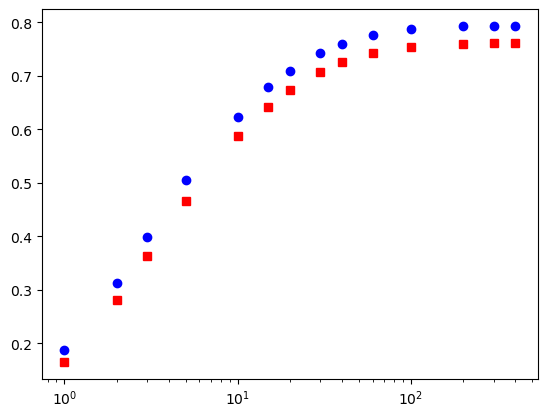

In [38]:
predictions_CTM = algoCTM.test(testset)
predictions_SVD = algoSVD.test(testset)
num_k = [1, 2, 3, 5, 10, 15, 20, 30, 40, 60, 100, 200, 300, 400]
recall_CTM = np.zeros((len(num_k),))
recall_SVD = np.zeros((len(num_k),))
for j, kk in enumerate(num_k):
    _, recalls = precision_recall_at_k(predictions_CTM, k=kk, threshold=3.25)
    recall_CTM[j] = sum(rec for rec in recalls.values()) / len(recalls)

    _, recalls = precision_recall_at_k(predictions_SVD, k=kk, threshold=3.25)
    recall_SVD[j] = sum(rec for rec in recalls.values()) / len(recalls)


fig, ax = plt.subplots(1, 1)

plt.semilogx(num_k, recall_SVD, 'rs')
plt.semilogx(num_k, recall_CTM, 'bo')

# Out of matrix predictions

In [31]:

# form dataset for CTM algorithm
reader = Reader(rating_scale=(1.0, 5.0))
df_ratings_matrix = df_final[['userId', 'recsys_id', 'rating']]
df_ratings_matrix = df_ratings_matrix.iloc[0:1_000_000].copy()
df_ratings_matrix = df_ratings_matrix.reset_index(drop=True)

unique_movies = df_ratings_matrix['recsys_id'].unique()

train_num = int(0.80*len(unique_movies)) 
train_ids = np.random.choice(unique_movies, size=train_num, replace=False)
test_ids = np.setdiff1d(unique_movies, train_ids)


train_ilocs = [j for j in range(len(df_ratings_matrix)) if df_ratings_matrix.loc[j, 'recsys_id'] in train_ids]
test_ilocs = [j for j in range(len(df_ratings_matrix)) if df_ratings_matrix.loc[j, 'recsys_id'] in test_ids]

df_train = df_ratings_matrix.iloc[train_ilocs]
df_test = df_ratings_matrix.iloc[test_ilocs]

# randomize training set
reader= Reader(rating_scale=(1.0, 5.0))
data = Dataset.load_from_df(df_train, reader)
trainset = data.build_full_trainset()

# for val set for test
data_test = Dataset.load_from_df(df_test, reader)
_, testset = train_test_split(data_test, test_size=1.0)


In [33]:
algoCTM = CTM(n_epochs=80, reg_all=0.08, reg_theta=0.2)
algoCTM.fit(trainset)
 # return rating based on LDA topics and user vectors
print(f'CTM Test RMSE: {rmse(algoCTM.test(testset), verbose=False)}') 

algoSVD = SVD(n_epochs=80, reg_all=0.08, n_factors=20)
algoSVD.fit(trainset)
 # return global mean of training set plus user-specific bias
print(f'SVD Test RMSE: {rmse(algoSVD.test(testset), verbose=False)}') 

CTM Test RMSE: 0.9677563029205911
SVD Test RMSE: 0.974363887071155


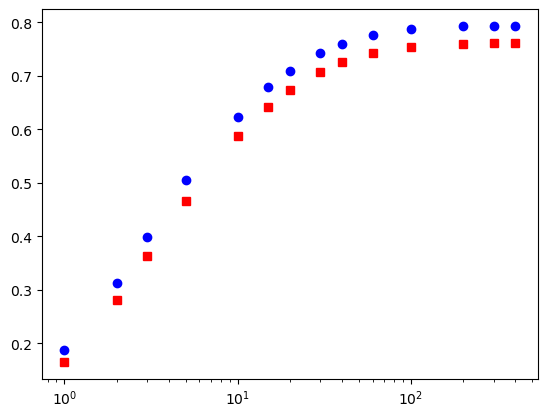

In [37]:
predictions_CTM = algoCTM.test(testset)
predictions_SVD = algoSVD.test(testset)
num_k = [1, 2, 3, 5, 10, 15, 20, 30, 40, 60, 100, 200, 300, 400]
recall_CTM = np.zeros((len(num_k),))
recall_SVD = np.zeros((len(num_k),))
for j, kk in enumerate(num_k):
    _, recalls = precision_recall_at_k(predictions_CTM, k=kk, threshold=3.25)
    recall_CTM[j] = sum(rec for rec in recalls.values()) / len(recalls)

    _, recalls = precision_recall_at_k(predictions_SVD, k=kk, threshold=3.25)
    recall_SVD[j] = sum(rec for rec in recalls.values()) / len(recalls)


fig, ax = plt.subplots(1, 1)

plt.semilogx(num_k, recall_SVD, 'rs-')
plt.semilogx(num_k, recall_CTM, 'bo-')